In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import geopandas as gpd
from rasterio.plot import show
import rioxarray as riox
from rasterio.enums import Resampling
import folium
import geopandas as gpd
from scipy.special import expit
from rasterio.plot import show_hist
import rioxarray as riox
from rasterio.mask import mask
from rasterio.enums import Resampling
from scipy import stats
from sklearn.linear_model import HuberRegressor
import earthpy.plot as ep
from scipy.stats import zscore
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show_hist

### Reshaping

In [2]:
input_files = ['Land Use and Agriculture.tiff', 'Human_factors.tiff','Atmospheric_conditions.tiff','Water_related_Factors.tiff']
data = [rasterio.open(file).read(1) for file in input_files]
for d in data:
    print(d.shape)

(377, 1051)
(361, 1047)
(362, 1046)
(362, 1046)


In [3]:
def resample_raster(input_file, reference_file, output_file):
    # Open the input and reference files
    with rasterio.open(input_file,masked=True) as src, rasterio.open(reference_file,masked=True) as ref:
        # Calculate the transform and dimensions for the new raster
        transform, width, height = calculate_default_transform(
            src.crs, ref.crs, ref.width, ref.height, *ref.bounds)

        # Update the metadata for the new raster
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': ref.crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create the new raster
        with rasterio.open(output_file, 'w', **kwargs) as dst:
            # Reproject and resample the input raster to match the reference raster
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=ref.crs,
                resampling=Resampling.bilinear)

In [4]:
resample_raster('Atmospheric_conditions.tiff','Water_related_Factors.tiff','resample_Atmospheric_conditions.tiff')
resample_raster('Human_factors.tiff','Water_related_Factors.tiff','resample_Human_factors.tiff')
resample_raster('Land Use and Agriculture.tiff','Water_related_Factors.tiff','resample_Land Use and Agriculture.tiff')

In [5]:
input_files = ['Water_related_Factors.tiff','resample_Atmospheric_conditions.tiff','resample_Human_factors.tiff','resample_Land Use and Agriculture.tiff']

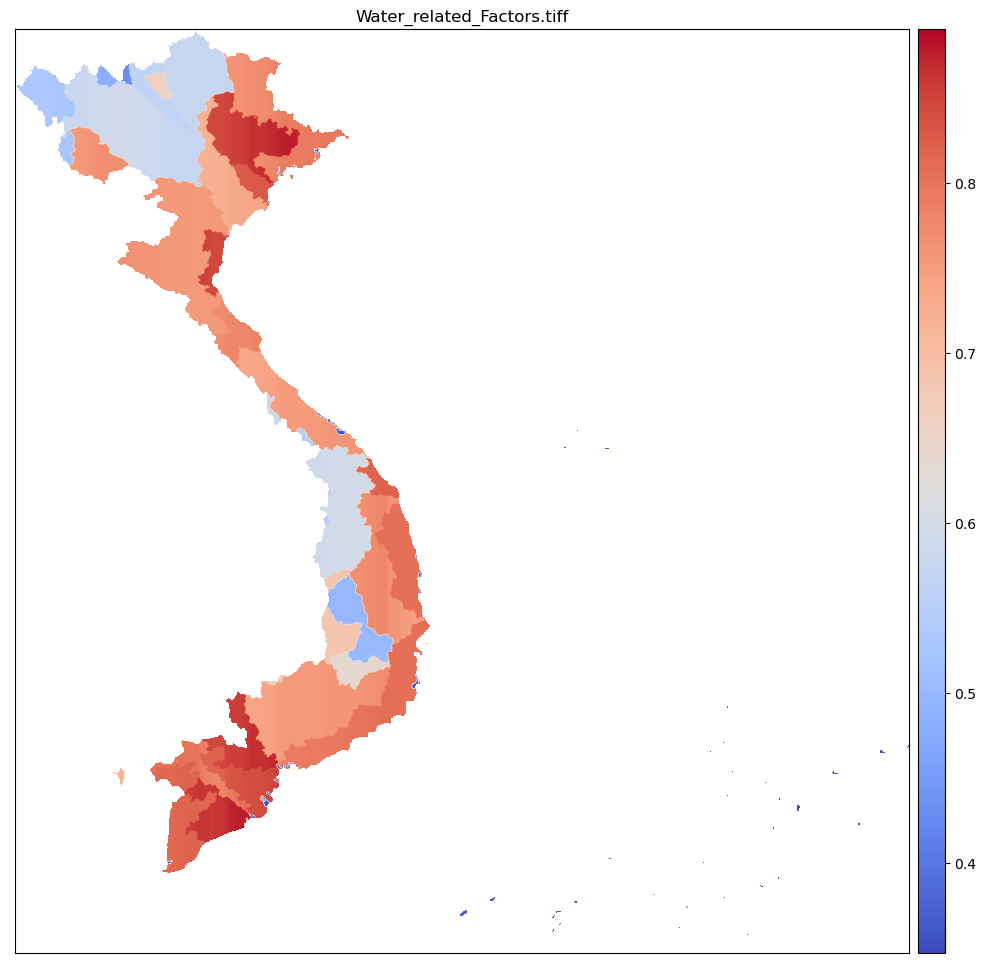

(0.007289344581910053, 0.007289344581910053)


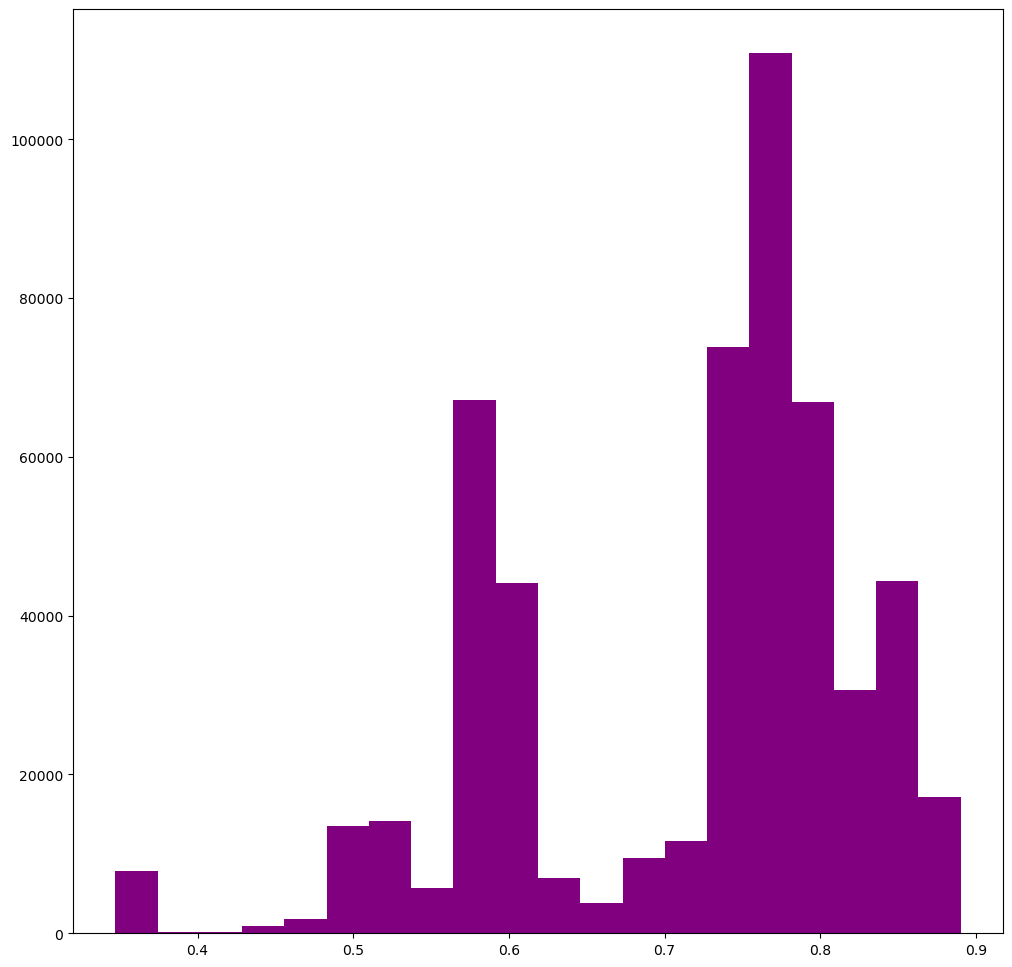

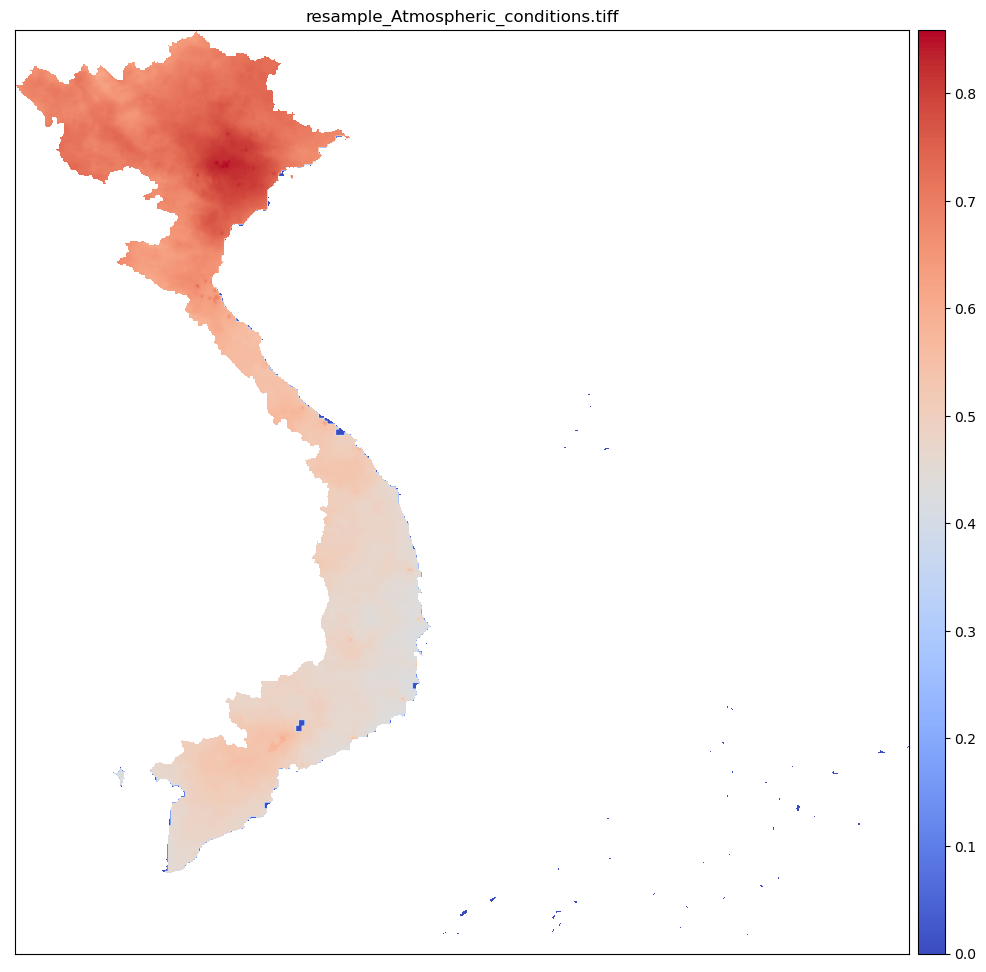

(0.007289344581910054, 0.007289344581910054)


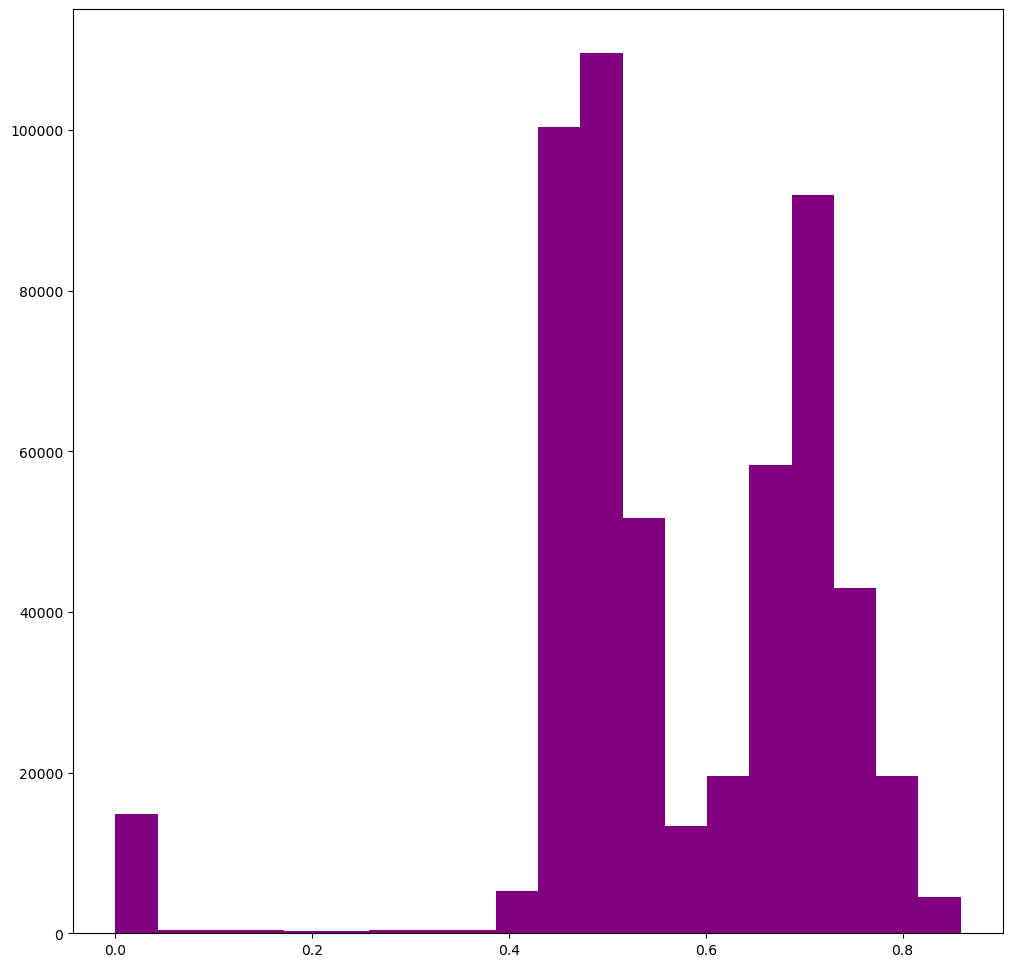

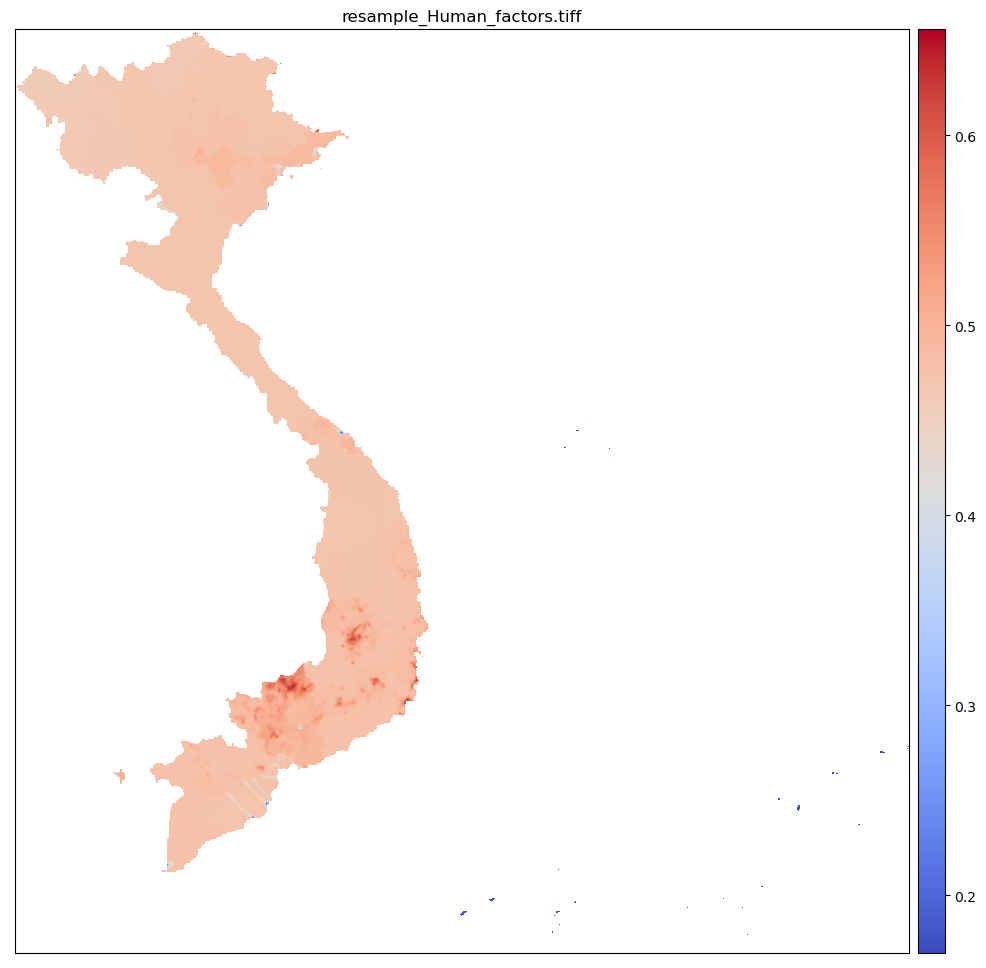

(0.007289344581910054, 0.007289344581910054)


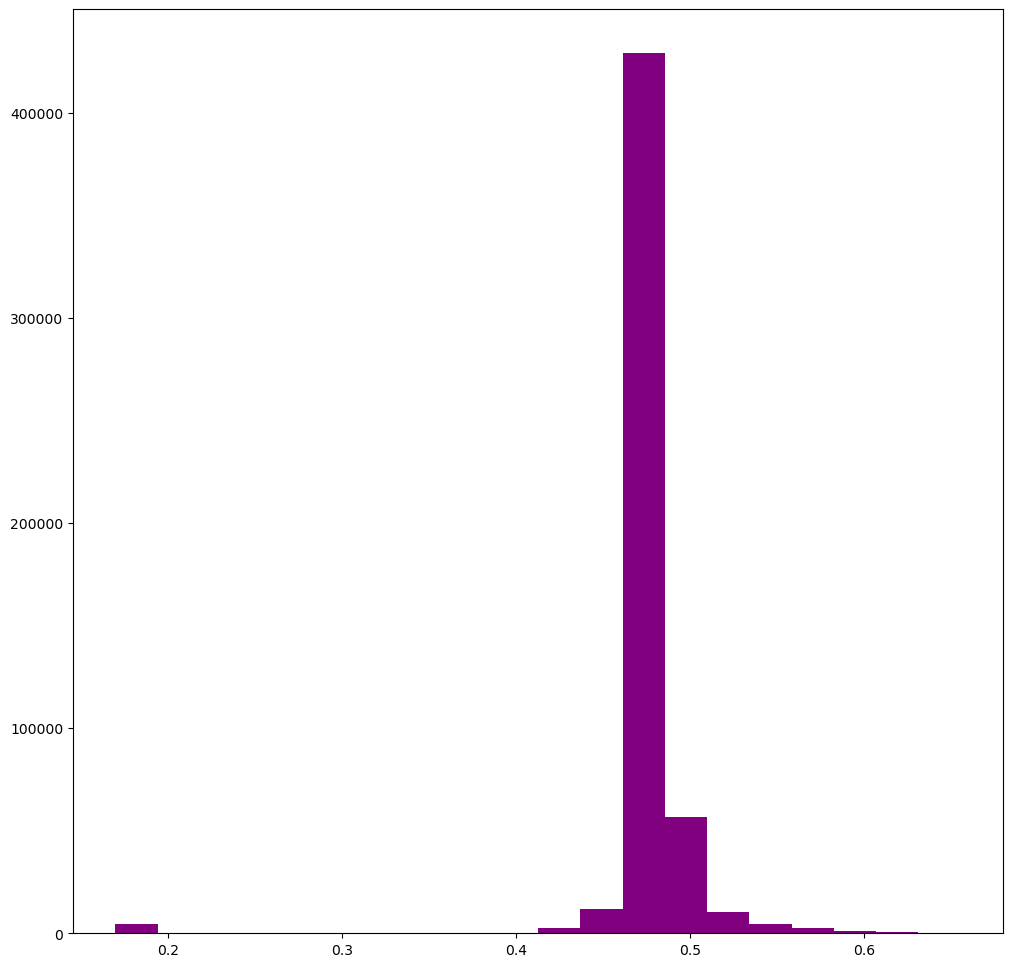

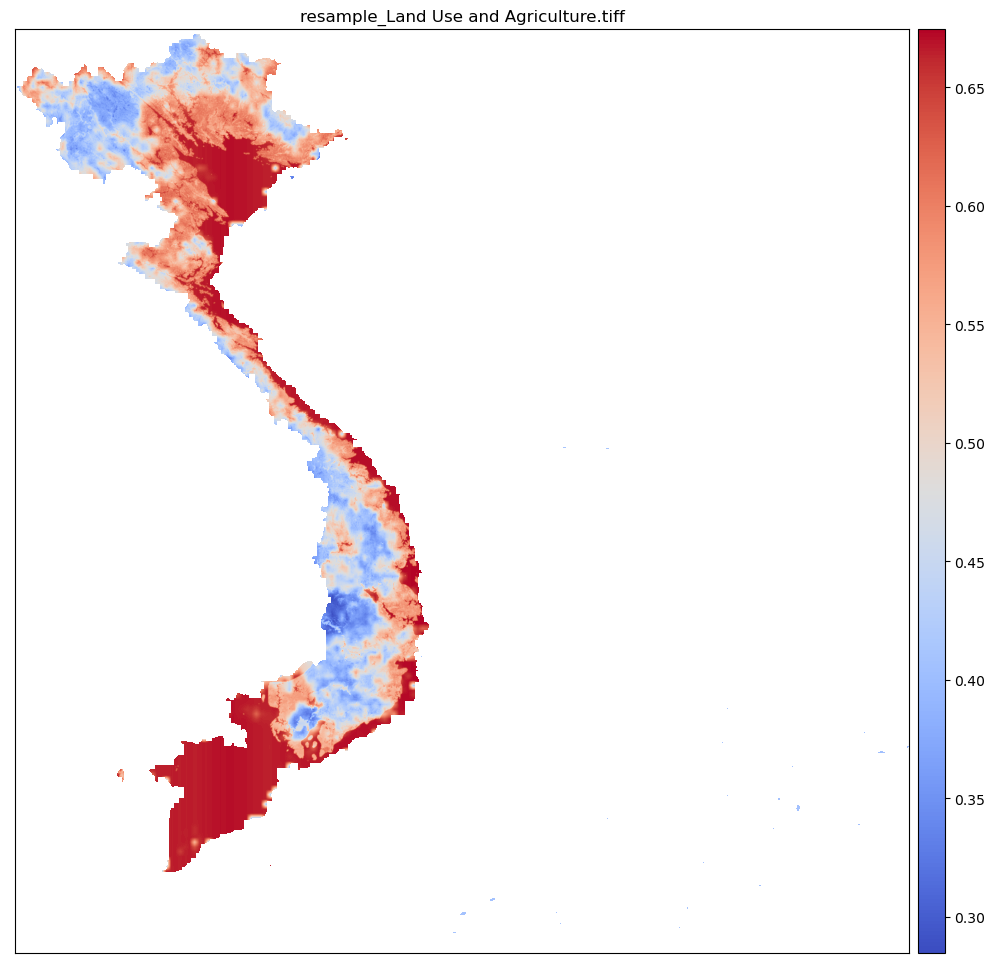

(0.007289344581910054, 0.007289344581910054)


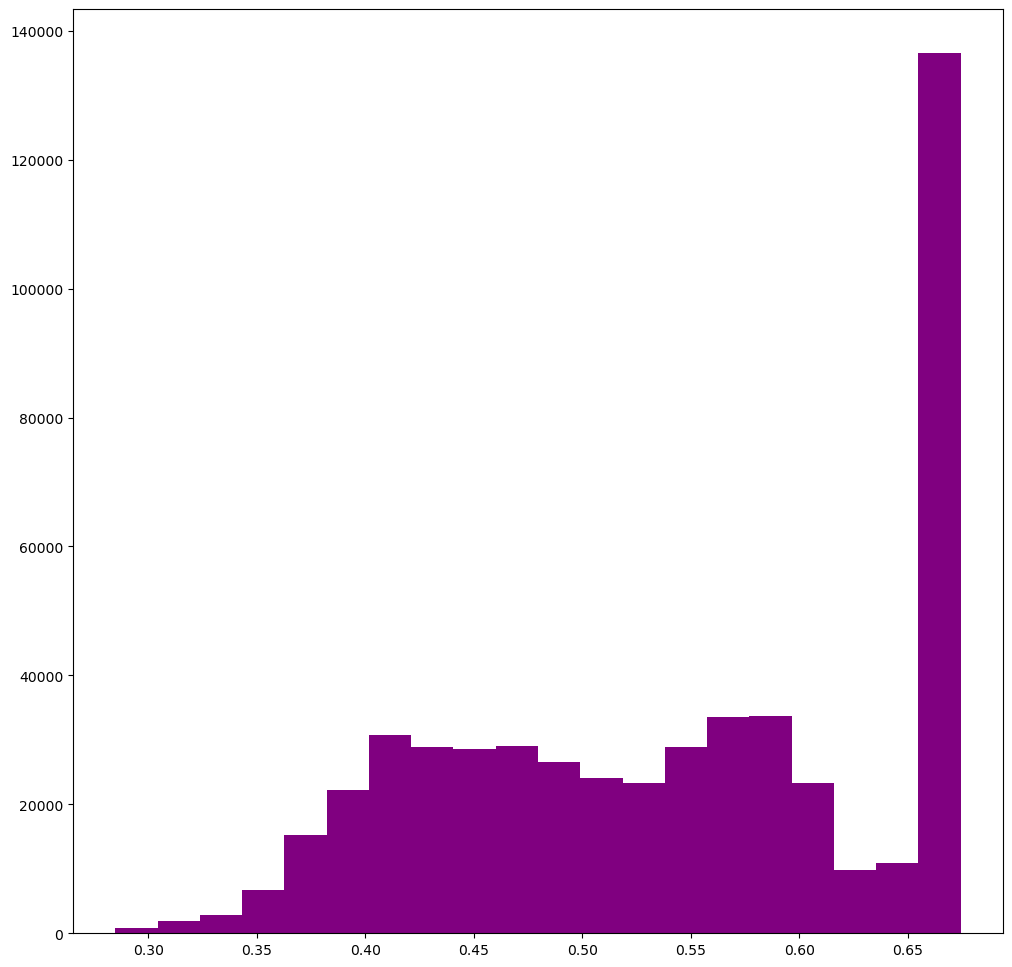

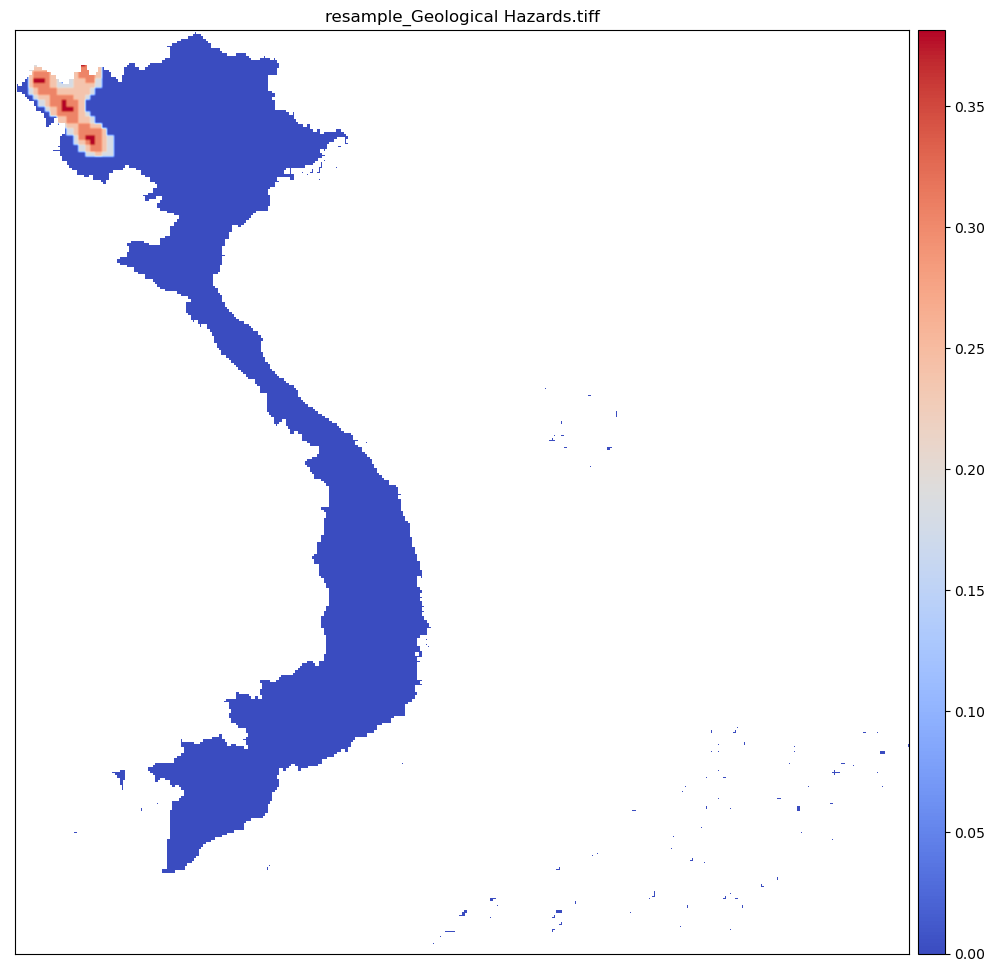

(0.007289344581910054, 0.007289344581910054)


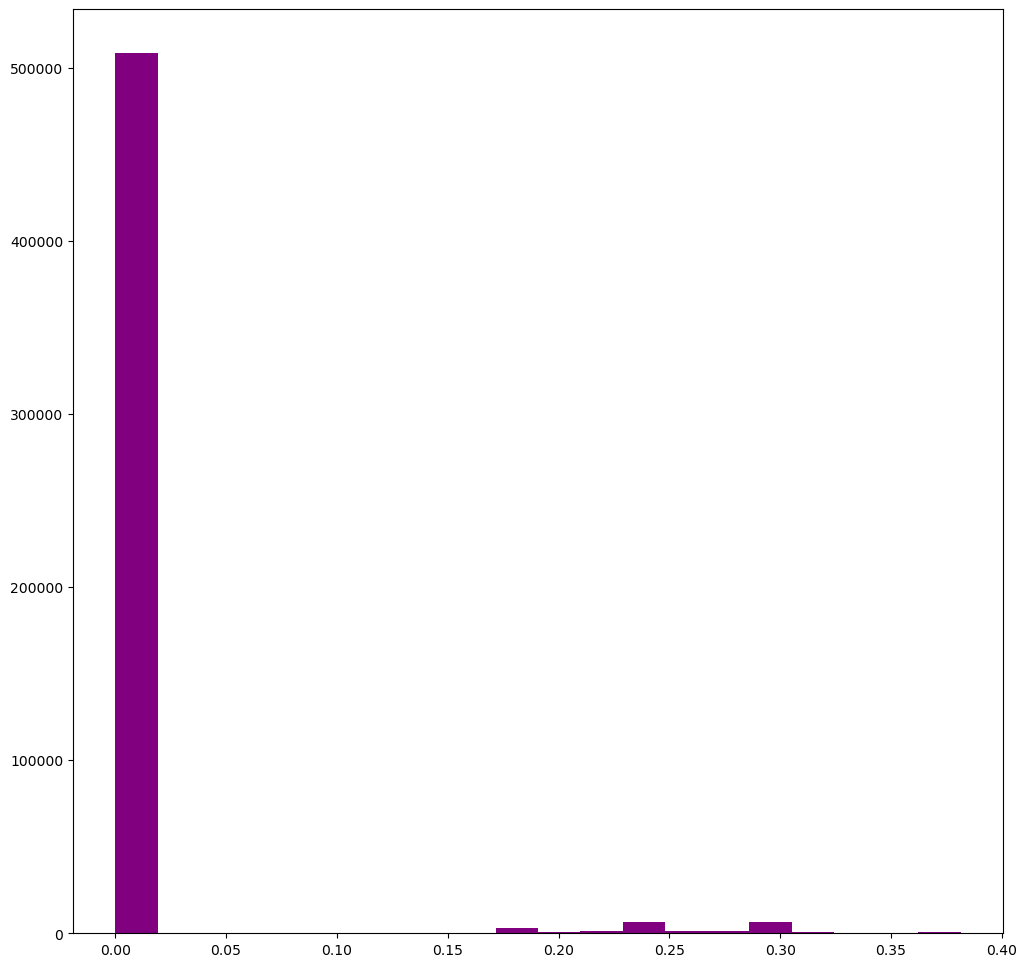

In [36]:
for files in input_files:
    with rasterio.open(files) as src:
        img = src.read(1)
    
    ep.plot_bands(img,cmap='coolwarm',title=files)
    ep.hist(img)
    print(src.res)

        

### Climate Aggregation Prototype

#### Trimmed Mean

In [6]:
def trimmed_mean_aggregation(input_files, output_file, proportiontocut=0.1):
    # Read the data from the input files
    data = [rasterio.open(file).read(1) for file in input_files]

    # Calculate the trimmed mean
    trimmed_mean = stats.trim_mean(data, proportiontocut, axis=0)

    # Get the metadata from the first input file
    with rasterio.open(input_files[0]) as src:
        meta = src.meta

    # Update the metadata to reflect the number of layers in the output file
    meta.update(count=1)

    # Write the trimmed mean to the output file
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(trimmed_mean, 1)

In [7]:
trimmed_mean_aggregation(input_files,'trimmed_mean_index.tif')

#### M-huber Estimator

In [8]:
def huber_aggregation(input_files, output_file):
    # Initialize an array to hold the transformed data
    transformed_data = []

    for file in input_files:
        # Read the data from the input file
        data = rasterio.open(file).read(1).flatten()

        # Create a mask of non-NaN values
        mask = ~np.isnan(data)

        # Fit the HuberRegressor model on non-NaN data
        huber = HuberRegressor().fit(np.arange(len(data[mask])).reshape(-1, 1), data[mask])

        # Predict the M-Huber estimate
        huber_estimate = np.full(data.shape, np.nan)
        huber_estimate[mask] = huber.predict(np.arange(len(data[mask])).reshape(-1, 1))

        # Append the estimate to the transformed data
        transformed_data.append(huber_estimate)

    # Stack the transformed data along a new dimension
    transformed_data = np.stack(transformed_data)

    # Get the metadata from the first input file
    with rasterio.open(input_files[0]) as src:
        meta = src.meta

    # Update the metadata to reflect the number of layers in the output file
    meta.update(count=len(input_files))

    # Write the M-Huber estimates to the output file
    with rasterio.open(output_file, 'w', **meta) as dst:
        for i, estimate in enumerate(transformed_data, start=1):
            dst.write(estimate.reshape(src.shape), i)


In [9]:
huber_aggregation(input_files,'huber_index.tif')

#### Median

In [10]:
def median_aggregation(input_files, output_file):
    # Read the data from the input files
    data = [rasterio.open(file).read(1) for file in input_files]

    # Calculate the median
    median = np.median(data, axis=0)

    # Get the metadata from the first input file
    with rasterio.open(input_files[0]) as src:
        meta = src.meta

    # Update the metadata to reflect the number of layers in the output file
    meta.update(count=1)

    # Write the median to the output file
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(median, 1)

In [11]:
median_aggregation(input_files,'median_index.tif')

### Visualisation

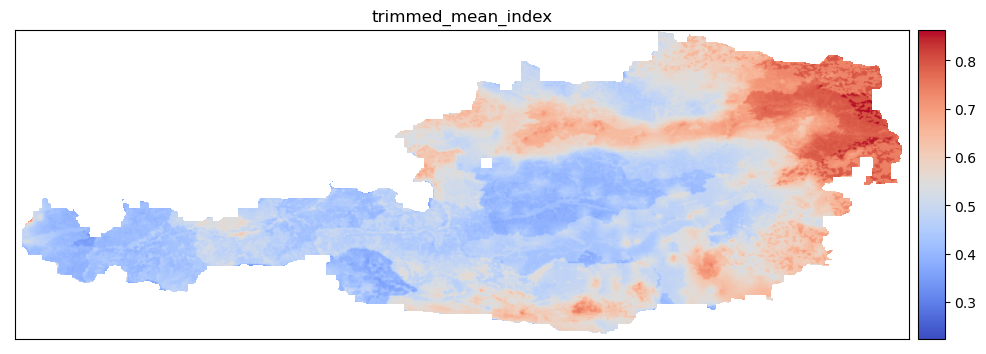

(0.0072944550669216054, 0.007292817679558019)


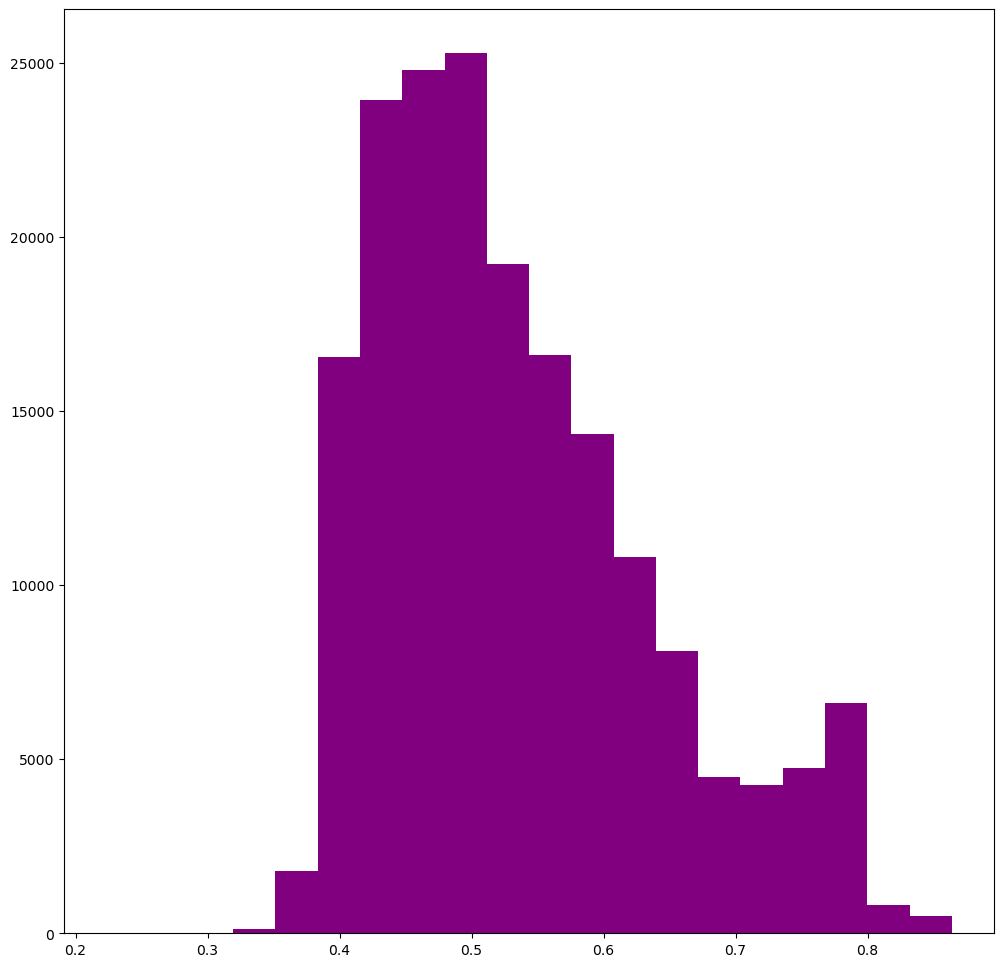

In [12]:
with rasterio.open('trimmed_mean_index.tif') as tkn:
    img = tkn.read(1)
    img_meta = tkn.meta
    tkn
ep.plot_bands(img,cmap='coolwarm',title="trimmed_mean_index")
ep.hist(img)
print(tkn.res)

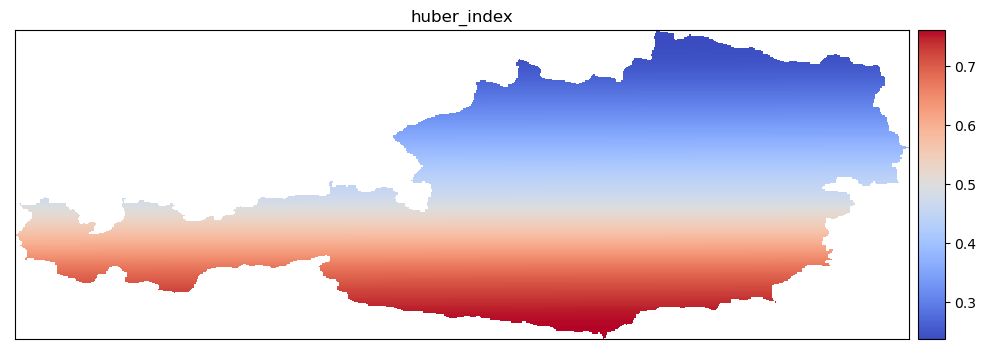

(0.0072944550669216054, 0.007292817679558019)


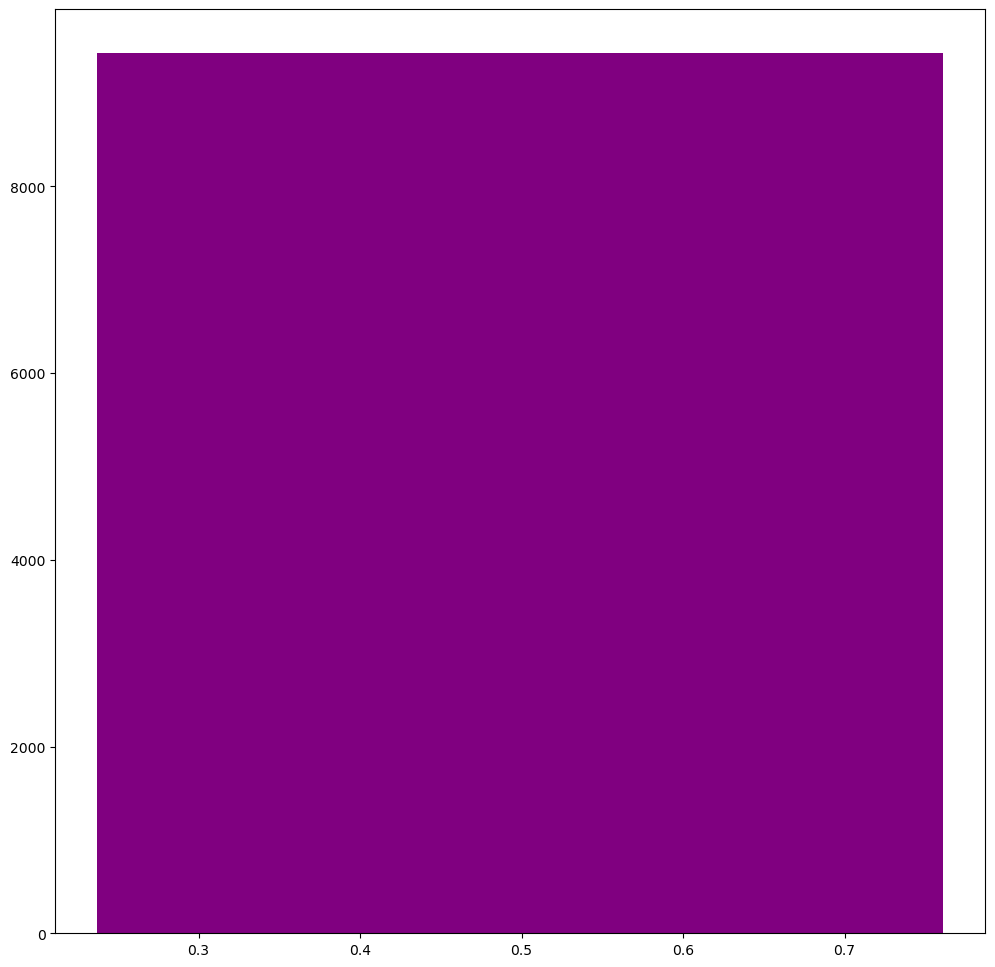

In [13]:
with rasterio.open('huber_index.tif') as tkn:
    img = tkn.read(1)
    img_meta = tkn.meta
    tkn
ep.plot_bands(img,cmap='coolwarm',title="huber_index")
ep.hist(img)
print(tkn.res)

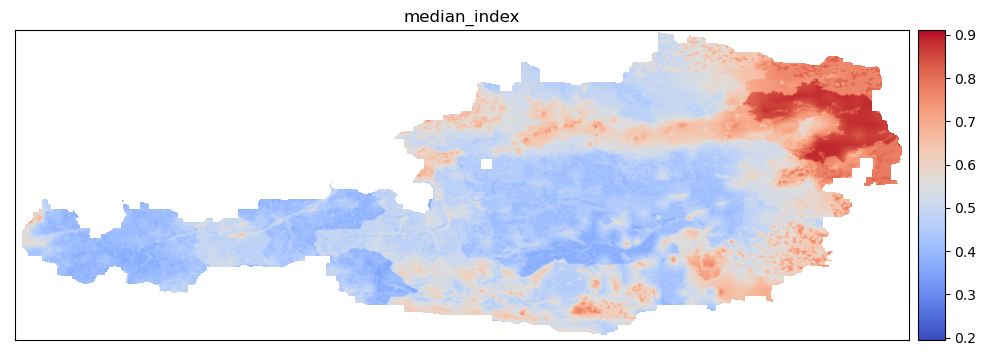

(0.0072944550669216054, 0.007292817679558019)


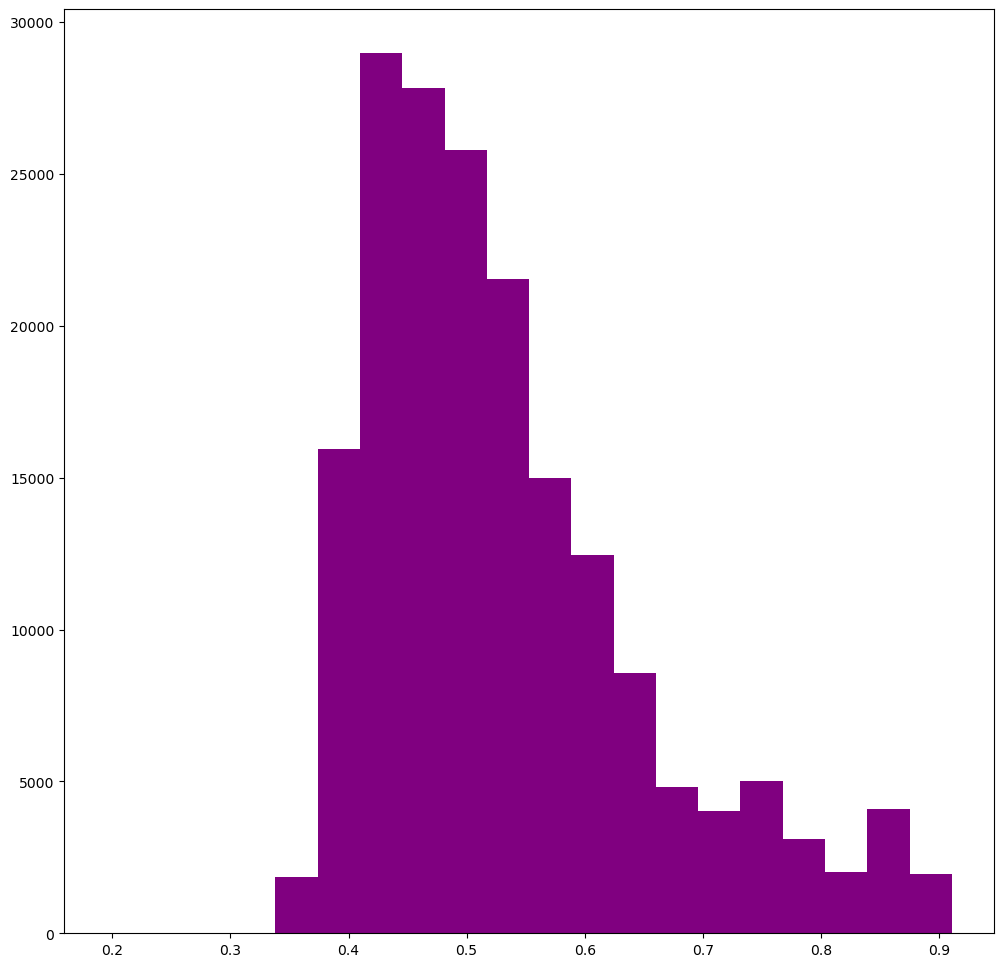

In [14]:
with rasterio.open('median_index.tif') as tkn:
    img = tkn.read(1)
    img_meta = tkn.meta
    tkn
ep.plot_bands(img,cmap='coolwarm',title="median_index")
ep.hist(img)
print(tkn.res)